# Gym environments

## Installing gym

In this course, we will mostly address RL environments available in the **OpenAI Gym** framework:

<https://gym.openai.com>

It provides a multitude of RL problems, from simple text-based problems with a few dozens of states (Gridworld, Taxi) to continuous control problems (Cartpole, Pendulum) to Atari games (Breakout, Space Invaders) to complex robotics simulators (Mujoco, but the license is expensive):

<https://gym.openai.com/envs>

We start by installing gym and its dependencies. Unfortunately, gym only works fully under Linux or MacOS. You can `pip install gym` on Windows, but will be limited to the most simple environments, excluding for example Atari games (but you can try these instructions: <https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30>). This isn't a big issue as we will only use the simple environments in the exercises, but less fun.

Moreover, it does not work out-of-the-box on colab, as gym opens graphical windows for some environments (e.g. Atari games), what is not possible in the browser. The first cell provides a workaround.

### On your computer

On your computer, you first need to make sure you have the right dependencies, especially `cmake`:

**Ubuntu Linux:**

```bash
apt-get install libglu1-mesa-dev libgl1-mesa-dev libosmesa6-dev xvfb ffmpeg curl patchelf libglfw3 libglfw3-dev cmake zlib1g zlib1g-dev swig
```

**MacOSX:**

```bash
brew install cmake swig boost boost-python sdl2 wget
```

On Windows, you may have to have Microsoft Visual C++ build tools installed. The link <https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30> suggests the 2017 version, but Visual C++ 2015-2019 Redistributable seems to also work.

You can then install gym in two steps, installing the `atari_py` dependency in between to be able to play Atari games.

```bash
pip install gym
pip install atari_py
pip install gym[atari]
```

### On Colab

On Colab, we need to install a bunch of dependencies (Colab runs a Debian VM under the hood) and define a visualization function that can be called at the end of an episode to visualize it. 

The following cell detects whether you run this notebook on colab or not, and imports lots of additional stuff if needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
    
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if not IN_COLAB:
    import gym
    def show_video():
        pass
    def wrap_env(env):
        return env
else:
    # Installing Debian and pip packages. It can take a while.
    # remove " > /dev/null 2>&1" to see what is going on under the hood
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !apt-get update > /dev/null 2>&1
    !apt-get install cmake > /dev/null 2>&1
    !pip install --upgrade setuptools 2>&1
    !pip install ez_setup > /dev/null 2>&1
    !pip install gym[atari] > /dev/null 2>&1
    
    import gym

    from gym.wrappers import Monitor
    import random, math, glob, io, base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

    def show_video():
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
        else: 
            print("Could not find video")

    def wrap_env(env):
        env = Monitor(env, './video', force=True)
        return env

## Gym interface 

The main interest of gym is that all problems have a common interface defined by the class `gym.Env`. There are only three methods that have to be implemented and used when creating a new environment:

* `state = env.reset()` restarts the environment and returns an initial state $s_0$.

* `state, reward, done, info = env.step(action)` takes an action $a_t$ and returns the new state $s_{t+1}$, the reward $r_{t+1}$, a boolean flag indicating whether the current state is terminal and a dictionary containing additional info for debugging (you can ignore it most of the time).

* `env.render()` displays the current state of the MDP, either text-based or in a graphical window. When training, this should not be called to save some time.

Additionally, you override the constructor `__init__()` to setup the state space (called observation space) and the action space. 

State and action space can either be :

* discrete (`gym.spaces.Discrete(nb_states)`), with states being an integer between 0 and `nb_states` -1.

* feature-based (`gym.spaces.Box(low=0, high=255, shape=(SCREEN_HEIGHT, SCREEN_WIDTH, 3))`) for pixel frames.

* continuous:

```python
gym.spaces.Tuple(
    gym.spaces.Box(-180.0, 180.0, 1), # First joint
    gym.spaces.Box(-180.0, 180.0, 1)  # Second joint    
)
```

Here is an example of a dummy environment with discrete states and actions, where the transition probabilities and rewards are completely random:

In [2]:
class FooEnv(gym.Env):
    """Dummy gym-like environment."""

    def __init__(self, nb_states, nb_actions):
        "Initialize the environment, can accept additional parameters such as the number of states and actions."
        
        # State space, can be discrete or continuous.
        self.observation_space = gym.spaces.Discrete(nb_states)
        
        # Action space, can be discrete or continuous.
        self.action_space = gym.spaces.Discrete(nb_actions)    
        
        super().__init__()
    
    def reset(self):
        "Resets the environment and starts from an initial state."
        
        # Sample one state randomly 
        self.state = self.observation_space.sample()
        
        return self.state
    
    def step(self, action):
        """
        Takes an action and returns a new state, a reward, a boolean (True for terminal states) 
        and a dictionary with additional info (optional).
        """
        
        self.state = self.observation_space.sample() # Random transition to another state
        self.reward = np.random.uniform(0, 1, 1)[0] # Random reward
        self.done = False # Continuing task
        self.info = {} # No info
        
        return self.state, self.reward, self.done, self.info

    def render(self, mode='human'):
        "Displays the current state of the environment. Can be text or video frames."
        
        print(self.state)
    
    def close(self):
        "To be called before exiting, to free resources (not needed here)."
        pass

With this interface, we can interact with the environment in a standardized way:

* We first create the environment.

* We pick an initial state with `reset()`.

* For a fixed number of steps (or until the episode terminates):

    * We render the current state with `render()`.
    
    * We select an action using our RL algorithm or randomly.
    
    * We take that action (`step()`), observe the new state and the reward.
    
    * We go into the new state.

In [3]:
# Create the environment
env = FooEnv(10, 4)

# Sample the initial state
state = env.reset()

# Sample 10 transitions
for t in range(10):
    
    # Render the current state
    env.render()

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, done, info = env.step(action)
    
    # Go in the next state
    state = next_state

# Exit cleanly
env.close()

1
0
9
9
8
0
6
2
6
6


That's it. To use any of the gym environments, replace the creation of the `FooEnv` instance by:

```python
env = wrap_env(gym.make('CartPole-v0'))
```

if you want to interact with the Cartpole environment. `wrap_env()` is obligatory on Colab, otherwise you will not be able to visualize it. You can omit it on your computer. For text-based environments such as `FooEnv`, you do not need to wrap the environment.

Each environment has a unique key, with a version number (`v0`). To have a list of the available environments, call:

In [ ]:
envs = gym.envs.registry.all()
for env in envs:
    print(env)

**Q:** Interact randomly with many gym environments (Cartpole, Pendulum, Breakout, SpaceInvaders, etc). Print the rewards you obtain.

*Note 1:* If you run a fixed number of steps, you should reset the environment when a terminal state is encountered, other wise you will be stuck in that terminal state:

```python
if done:
    state = env.reset()
```

*Note 2:* If you stop the execution of a cell but the window does not close, run `env.close()` in a separate cell.

*Note 3:* Some environments are very fast, especially Atari games. A simple solution is to have python **sleep** a bit after rendering a frame, so that you can see something:

```python
import time
# ...
for t in range(1000):
    env.render()
    time.sleep(0.01) # sleep 10 milliseconds
    # ...
```

*Note 4:* On Colab, `env.render()` will do nothing. You need to call `show_video()` after `env.close()` to see the movie of what happened.

In [ ]:
# Create the environment
env = wrap_env(gym.make('CartPole-v0'))

# Sample the initial state
state = env.reset()

# Sample 1000 transitions
for t in range(1000):
    
    # Render the current state
    env.render()

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, done, info = env.step(action)
    
    # Go in the next state
    state = next_state
    
    # If terminal, reset
    if done:
        state = env.reset()

# Exit cleanly
env.close()
show_video()

In [ ]:
# Create the environment
env = wrap_env(gym.make('SpaceInvaders-v0'))

# Sample the initial state
state = env.reset()

# Sample 1000 transitions
for t in range(1000):
    
    # Render the current state
    env.render()
    time.sleep(0.01)

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, done, info = env.step(action)
    
    # Go in the next state
    state = next_state
    
    # If terminal, reset
    if done:
        state = env.reset()

# Exit cleanly
env.close()
show_video()

## Recycling robot

**Q:** Create a `RecyclingRobot` gym-like environment using last week's exercise.

The parameters `alpha`, `beta`, `r_wait` and `r_search` should be passed to the constructor of the environment and saved as attributes.

The state space is discrete, with two states `high` and `low` which will have indices 0 and 1. The three discrete actions `search`, `wait` and `recharge` have indices 0, 1, and 2.

The initial state of the MDP (`reset()`) should be the high state.

The `step()` should generate transitions according to the dynamics of the MDP. Depending on the current state and the chosen action, make a transition to another state. For the actions `search` and `wait`, sample the reward from the normal distribution with mean `r_search` (resp. `r_wait`) and variance 0.5. 

If the random agent selects `recharge` in `high`, do nothing (next state is high, reward is 0).

Rendering is just printing the current state. There is nothing to close, so you do not even need to redefine the function.

Interact randomly with the MDP for several steps and observe the rewards. 

In [4]:
class RecyclingRobot(gym.Env):

    def __init__(self, alpha, beta, r_search, r_wait):
        "Initialize the environment."
        
        # Store parameters
        self.alpha = alpha
        self.beta = beta
        self.r_search = r_search
        self.r_wait = r_wait
        
        # State space, can be discrete or continuous.
        self.observation_space = gym.spaces.Discrete(2)        
        self.states =  ['high', 'low']
        
        # Action space, can be discrete or continuous.
        self.action_space = gym.spaces.Discrete(3)  
        self.actions = ['search', 'wait', 'recharge']  
        
        super().__init__()
    
    def reset(self):
        "Resets the environment and starts from an initial state."
        
        # Start in the high state
        self.state = 0
        
        return self.state
    
    def step(self, action):
        """Takes an action and returns a new state, a reward, a boolean (True for terminal states) 
        and a dictionary with additional info (optional)"""
        
        if self.state == 0: # high
            if action == 0: # search
                p = np.random.rand()
                if p < self.alpha:
                    self.state = 0 # high
                else:
                    self.state = 1 # low
                self.reward = float(np.random.normal(self.r_search, 0.5, 1))
            elif action == 1: # wait
                self.state = 0 # high
                self.reward = float(np.random.normal(self.r_wait, 0.5, 1))
            elif action == 2: # recharge
                self.state = 0 # high
                self.reward = 0.0
        elif self.state == 1: # low
            if action == 0: # search
                p = np.random.rand()
                if p < self.beta:
                    self.state = 1 # low
                    self.reward = float(np.random.normal(self.r_search, 0.5, 1))
                else:
                    self.state = 0 # high
                    self.reward = -3.0
            elif action == 1: # wait
                self.state = 1 # low
                self.reward = float(np.random.normal(self.r_wait, 0.5, 1))
            elif action == 2: # recharge
                self.state = 0 # high
                self.reward = 0.0
        
        return self.state, self.reward, False, {}

    def render(self, mode='human'):
        "Displays the current state of the environment. Can be text or video frames."
        
        print(self.states[self.state])

In [5]:
# Create the environment
env = RecyclingRobot(alpha=0.3, beta=0.2, r_search=6, r_wait=2)

# Sample the initial state
state = env.reset()

# Sample 10 transitions
for t in range(10):
    
    # Render the current state
    env.render()

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, done, info = env.step(action)
    
    print(env.states[state], "+", env.actions[action], "->", env.states[next_state], ":", reward)
    
    # Go in the next state
    state = next_state

# Exit cleanly
env.close()

high
high + recharge -> high : 0.0
high
high + search -> low : 6.6118721135640826
low
low + search -> high : -3.0
high
high + wait -> high : 1.1480821866278401
high
high + recharge -> high : 0.0
high
high + recharge -> high : 0.0
high
high + wait -> high : 2.0195456426113845
high
high + search -> high : 6.771869747290772
high
high + search -> high : 5.87638732830117
high
high + wait -> high : 1.9505921613705735


To be complete, let's implement the random agent as a class. The class should look like:

```python
class RandomAgent:
    """
    Random agent exploring uniformly the environment.
    """
    
    def __init__(self, env):
        """
        :param env: gym-like environment
        """
        self.env = env
    
    def act(self, state):
        "Returns a random action by sampling the action space."
        action = # TODO
        return action
    
    def update(self, state, action, reward, next_state):
        "Updates the agent using the transition (s, a, r, s')."
        pass
    
    def train(self, nb_steps, render=True):
        "Runs the agent on the environment for nb_steps. Returns the list of obtained rewards."
        
        # List of rewards
        rewards = []

        # TODO
            
        return rewards
```

The environment is passed to the constructor. `act(state)` should sample a random action. `update(state, action, reward, next_state)` does nothing for the random agent (`pass` is a Python command doing nothing), but we will implement it in the next exercises. 

`train(nb_steps, render)` implements the interaction loop between the agent and the environment for a fixed number of steps. It should return the list of obtained rewards. You can use the flag `render` to switch rendering or printing on and off.

**Q:** Implement the random agent and have it interact with the environment for a fixed number of steps.

In [6]:
class RandomAgent:
    """
    Random agent exploring uniformly the environment.
    """
    
    def __init__(self, env):
        """
        :param env: gym-like environment
        """
        self.env = env
    
    def act(self, state):
        "Returns a random action by sampling the action space."
        return self.env.action_space.sample()
    
    def update(self, state, action, reward, next_state):
        "Updates the agent using the transition (s, a, r, s')."
        pass
    
    def train(self, nb_steps, render=True):
        "Runs the agent on the environment for nb_steps. Returns the list of obtained rewards."

        # Sample the initial state
        state = self.env.reset()
        
        # List of rewards
        rewards = []

        # Sample nb_steps transitions
        for t in range(nb_steps):

            # Render the current state
            if render:
                self.env.render()

            # Select an action randomly
            action = agent.act(state)

            # Sample a single transition
            next_state, reward, done, info = self.env.step(action)

            if render:
                print(self.env.states[state], "+", self.env.actions[action], "->", self.env.states[next_state], ":", reward)
                
            # Append the reward
            rewards.append(reward)

            # Learn from the (s, a, r, s') transition
            agent.update(state, action, reward, next_state)

            # Go in the next state
            state = next_state
            
        return rewards

high
high + wait -> high : 1.184077553777401
high
high + search -> high : 6.316602781044177
high
high + search -> low : 5.92799122670519
low
low + search -> high : -3.0
high
high + search -> high : 5.749478044656084
high
high + search -> high : 5.859124009288839
high
high + search -> high : 6.121886291580505
high
high + search -> high : 5.896227740772887
high
high + recharge -> high : 0.0
high
high + wait -> high : 2.892363742574329


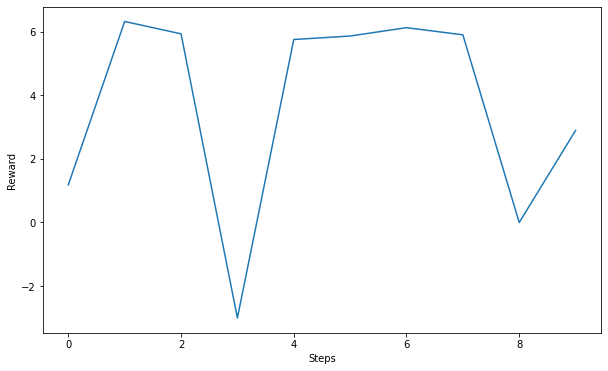

In [7]:
# Create the environment
env = RecyclingRobot(alpha=0.3, beta=0.2, r_search=6, r_wait=2)

# Creating the random agent
agent = RandomAgent(env)

# Train the agent for 10 steps
rewards = agent.train(10)

# Exit cleanly
env.close()

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

That's it! We now "only" need to define classes for all the sampling-based RL algorithms (MC, TD, deep RL) and we can interact with any environment using the previous cell!